The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [3]:
!pip install git+https://github.com/d2l-ai/d2l-zh@release --no-deps


  Cloning https://github.com/d2l-ai/d2l-zh (to revision release) to /tmp/pip-req-build-maks0ea4
  Running command git clone --filter=blob:none --quiet https://github.com/d2l-ai/d2l-zh /tmp/pip-req-build-maks0ea4
  Running command git checkout -b release --track origin/release
  Switched to a new branch 'release'
  Branch 'release' set up to track remote branch 'release' from 'origin'.
  Resolved https://github.com/d2l-ai/d2l-zh to commit 843d3d41dca48d8df65f4b324dd171d8bfe9c067
  Running command git submodule update --init --recursive -q
  Preparing metadata (setup.py) ... done
  Created wheel for d2l: filename=d2l-2.0.0-py3-none-any.whl size=110800 sha256=85e5f2e05b9e2b04450229ecf5302510ed427d4e6f50ac407aa1d8cb154b2da0
  Stored in directory: /tmp/pip-ephem-wheel-cache-n6vv5a7i/wheels/3e/87/36/53b013ece7da539a59fcc56da2d329d7afb08eef9a9a5ae1d1
Successfully built d2l


# 预训练word2vec
:label:`sec_word2vec_pretraining`

我们继续实现 :numref:`sec_word2vec`中定义的跳元语法模型。然后，我们将在PTB数据集上使用负采样预训练word2vec。首先，让我们通过调用`d2l.load_data_ptb`函数来获得该数据集的数据迭代器和词表，该函数在 :numref:`sec_word2vec_data`中进行了描述。


In [4]:
import math
import torch
from torch import nn
from d2l import torch as d2l

batch_size, max_window_size, num_noise_words = 512, 5, 5
data_iter, vocab = d2l.load_data_ptb(batch_size, max_window_size, num_noise_words)

正在从http://d2l-data.s3-accelerate.amazonaws.com/ptb.zip下载../data/ptb.zip...


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


## 跳元模型

我们通过嵌入层和批量矩阵乘法实现了跳元模型。首先，让我们回顾一下嵌入层是如何工作的。

### 嵌入层

如 :numref:`sec_seq2seq`中所述，嵌入层将词元的索引映射到其特征向量。该层的权重是一个矩阵，其行数等于字典大小（`input_dim`），列数等于每个标记的向量维数（`output_dim`）。在词嵌入模型训练之后，这个权重就是我们所需要的。


In [5]:
embed = nn.Embedding(num_embeddings=20, embedding_dim=4)
print(f'Parameter embedding_weight ({embed.weight.shape}, '
      f'dtype={embed.weight.dtype})')

Parameter embedding_weight (torch.Size([20, 4]), dtype=torch.float32)


嵌入层的输入是词元（词）的索引。对于任何词元索引$i$，其向量表示可以从嵌入层中的权重矩阵的第$i$行获得。由于向量维度（`output_dim`）被设置为4，因此当小批量词元索引的形状为（2，3）时，嵌入层返回具有形状（2，3，4）的向量。


In [6]:
x = torch.tensor([[1, 2, 3], [4, 5, 6]])
embed(x)

tensor([[[-0.9793, -1.2857,  0.7214,  0.1937],
         [ 0.4413,  0.3982,  0.3486, -0.7128],
         [-1.5423,  3.6233,  0.1265,  1.8637]],

        [[-0.0463, -0.1003,  0.3898, -0.7535],
         [-1.3848,  1.1010,  1.2758,  1.4818],
         [-1.7542, -0.1933, -0.7431, -1.7637]]], grad_fn=<EmbeddingBackward0>)

### 定义前向传播

在前向传播中，跳元语法模型的输入包括形状为（批量大小，1）的中心词索引`center`和形状为（批量大小，`max_len`）的上下文与噪声词索引`contexts_and_negatives`，其中`max_len`在 :numref:`subsec_word2vec-minibatch-loading`中定义。这两个变量首先通过嵌入层从词元索引转换成向量，然后它们的批量矩阵相乘（在 :numref:`subsec_batch_dot`中描述）返回形状为（批量大小，1，`max_len`）的输出。输出中的每个元素是中心词向量和上下文或噪声词向量的点积。


In [7]:
def skip_gram(center, contexts_and_negatives, embed_v, embed_u):
    v = embed_v(center)
    u = embed_u(contexts_and_negatives)
    pred = torch.bmm(v, u.permute(0, 2, 1))
    return pred

让我们为一些样例输入打印此`skip_gram`函数的输出形状。


In [8]:
skip_gram(torch.ones((2, 1), dtype=torch.long),
          torch.ones((2, 4), dtype=torch.long), embed, embed).shape

torch.Size([2, 1, 4])

## 训练

在训练带负采样的跳元模型之前，我们先定义它的损失函数。

### 二元交叉熵损失

根据 :numref:`subsec_negative-sampling`中负采样损失函数的定义，我们将使用二元交叉熵损失。


In [9]:
class SigmoidBCELoss(nn.Module):
    # 带掩码的二元交叉熵损失
    def __init__(self):
        super().__init__()

    def forward(self, inputs, target, mask=None):
        out = nn.functional.binary_cross_entropy_with_logits(
            inputs, target, weight=mask, reduction="none")
        return out.mean(dim=1)

loss = SigmoidBCELoss()

回想一下我们在 :numref:`subsec_word2vec-minibatch-loading`中对掩码变量和标签变量的描述。下面计算给定变量的二进制交叉熵损失。


In [10]:
pred = torch.tensor([[1.1, -2.2, 3.3, -4.4]] * 2)
label = torch.tensor([[1.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0]])
mask = torch.tensor([[1, 1, 1, 1], [1, 1, 0, 0]])
loss(pred, label, mask) * mask.shape[1] / mask.sum(axis=1)

tensor([0.9352, 1.8462])

下面显示了如何使用二元交叉熵损失中的Sigmoid激活函数（以较低效率的方式）计算上述结果。我们可以将这两个输出视为两个规范化的损失，在非掩码预测上进行平均。


In [11]:
def sigmd(x):
    return -math.log(1 / (1 + math.exp(-x)))

print(f'{(sigmd(1.1) + sigmd(2.2) + sigmd(-3.3) + sigmd(4.4)) / 4:.4f}')
print(f'{(sigmd(-1.1) + sigmd(-2.2)) / 2:.4f}')

0.9352
1.8462


### 初始化模型参数

我们定义了两个嵌入层，将词表中的所有单词分别作为中心词和上下文词使用。字向量维度`embed_size`被设置为100。


In [12]:
embed_size = 100
net = nn.Sequential(nn.Embedding(num_embeddings=len(vocab),
                                 embedding_dim=embed_size),
                    nn.Embedding(num_embeddings=len(vocab),
                                 embedding_dim=embed_size))

### 定义训练阶段代码

训练阶段代码实现定义如下。由于填充的存在，损失函数的计算与以前的训练函数略有不同。


In [13]:
def train(net, data_iter, lr, num_epochs, device=d2l.try_gpu()):
    def init_weights(m):
        if type(m) == nn.Embedding:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    net = net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[1, num_epochs])
    # 规范化的损失之和，规范化的损失数
    metric = d2l.Accumulator(2)
    for epoch in range(num_epochs):
        timer, num_batches = d2l.Timer(), len(data_iter)
        for i, batch in enumerate(data_iter):
            optimizer.zero_grad()
            center, context_negative, mask, label = [
                data.to(device) for data in batch]

            pred = skip_gram(center, context_negative, net[0], net[1])
            l = (loss(pred.reshape(label.shape).float(), label.float(), mask)
                     / mask.sum(axis=1) * mask.shape[1])
            l.sum().backward()
            optimizer.step()
            metric.add(l.sum(), l.numel())
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[1],))
    print(f'loss {metric[0] / metric[1]:.3f}, '
          f'{metric[1] / timer.stop():.1f} tokens/sec on {str(device)}')

现在，我们可以使用负采样来训练跳元模型。


loss 0.410, 101770.1 tokens/sec on cuda:0


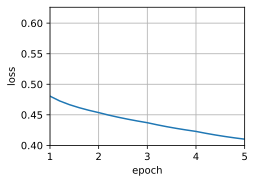

In [14]:
lr, num_epochs = 0.002, 5
train(net, data_iter, lr, num_epochs)

## 应用词嵌入
:label:`subsec_apply-word-embed`

在训练word2vec模型之后，我们可以使用训练好模型中词向量的余弦相似度来从词表中找到与输入单词语义最相似的单词。


In [16]:
def get_similar_tokens(query_token, k, embed):
    W = embed.weight.data
    x = W[vocab[query_token]]
    # 计算余弦相似性。增加1e-9以获得数值稳定性
    cos = torch.mv(W, x) / torch.sqrt(torch.sum(W * W, dim=1) *
                                      torch.sum(x * x) + 1e-9)
    topk = torch.topk(cos, k=k+1)[1].cpu().numpy().astype('int32')
    for i in topk[1:]:  # 删除输入词
        print(f'cosine sim={float(cos[i]):.3f}: {vocab.to_tokens(i)}')

get_similar_tokens('chip', 3, net[0])

cosine sim=0.713: intel
cosine sim=0.709: dell
cosine sim=0.641: disk


## 小结

* 我们可以使用嵌入层和二元交叉熵损失来训练带负采样的跳元模型。
* 词嵌入的应用包括基于词向量的余弦相似度为给定词找到语义相似的词。

## 练习

1. 使用训练好的模型，找出其他输入词在语义上相似的词。您能通过调优超参数来改进结果吗？
1. 当训练语料库很大时，在更新模型参数时，我们经常对当前小批量的*中心词*进行上下文词和噪声词的采样。换言之，同一中心词在不同的训练迭代轮数可以有不同的上下文词或噪声词。这种方法的好处是什么？尝试实现这种训练方法。


## 练习结果

1.我们使用训练好的模型，来找出其他输入词在语义上相似的词。

我们寻找几个常见词，如`man` `plant` `circle` `run`来进行这个测试。

In [17]:
for words in ['man', 'plant', 'circle', 'run']:
    # 使用前文定义的get_similar_tokens函数来实现
    get_similar_tokens(words, 3, net[0])

cosine sim=0.667: wearing
cosine sim=0.631: friend
cosine sim=0.609: invited
cosine sim=0.631: assembly
cosine sim=0.621: operation
cosine sim=0.608: builds
cosine sim=0.642: lawn
cosine sim=0.639: ruth
cosine sim=0.628: stars
cosine sim=0.455: guber-peters
cosine sim=0.447: 'll
cosine sim=0.441: provigo


  尝试通过调整超参数的方法来改善结果：我们将学习率`lr`调整至`0.0025`，`num_epoches`调整为`10`重新训练新的跳元模型进行测试：

loss 0.356, 218240.6 tokens/sec on cuda:0


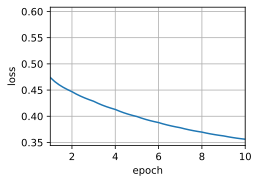

In [20]:
new_net = nn.Sequential(nn.Embedding(num_embeddings=len(vocab),
                                     embedding_dim=embed_size),
                        nn.Embedding(num_embeddings=len(vocab),
                                     embedding_dim=embed_size))
# 重新初始化new_net对象来调整超参数

new_lr, new_num_epochs = 0.0025, 10
train(new_net, data_iter, new_lr, new_num_epochs)

In [21]:
for words in ['man', 'plant', 'circle', 'run']:
    # 使用前文定义的get_similar_tokens函数来实现
    get_similar_tokens(words, 3, new_net[0])

cosine sim=0.452: recalls
cosine sim=0.447: gelbart
cosine sim=0.445: actor
cosine sim=0.593: plants
cosine sim=0.513: headquarters
cosine sim=0.503: toledo
cosine sim=0.497: lawn
cosine sim=0.455: foot
cosine sim=0.452: stars
cosine sim=0.399: film
cosine sim=0.397: guber-peters
cosine sim=0.396: owned


p.s. 感觉和之前的模型相比似乎有点进步，但是还是差点意思:b

2.
- 当语料库非常庞大时，这个预先生成的中心词-上下文词-负样本列表会变得极其巨大。而动态采样是在每个小批量（mini-batch）训练时才为其中心词生成上下文和负样本，只需要在内存中保留原始的语料库索引，极大地节省了内存空间。
- 对每个epoch，同一个中心词都会与动态采样出的不同的上下文词和不同的负样本词组合成新的训练样本。相当于一种数据增强（Data Augmentation），使得模型在每次迭代时都能看到略有不同的数据，有助于提高模型的泛化能力，防止过拟合。

以下是具体的实现：

In [34]:
import random
import torch
from torch.utils.data import TensorDataset, DataLoader

def generate_dynamic_data(corpus, vocab, counter, batch_size, max_window_size, num_noise_words):
    """为单个epoch动态生成数据。"""
    # 1. 动态采样上下文窗口大小
    all_centers, all_contexts = [], []
    for i, center in enumerate(corpus):
        # 为每个中心词随机选择一个1到max_window_size之间的窗口大小
        window_size = random.randint(1, max_window_size)
        indices = list(range(max(0, i - window_size), min(len(corpus), i + 1 + window_size)))
        indices.remove(i)  # 排除中心词本身
        contexts = [corpus[idx] for idx in indices]
        all_centers.append(center)
        all_contexts.append(contexts)

    # 2. 负采样
    sampling_weights = [counter[i]**0.75 for i in range(len(vocab))]
    population = list(range(len(vocab)))
    all_negatives = []

    num_neg_samples = sum(len(ctx) for ctx in all_contexts) * num_noise_words
    neg_candidates = random.choices(population, sampling_weights, k=num_neg_samples)

    neg_idx = 0
    for contexts in all_contexts:
        num_to_sample = len(contexts) * num_noise_words
        all_negatives.append(neg_candidates[neg_idx : neg_idx + num_to_sample])
        neg_idx += num_to_sample

    # 3. 构造批次数据
    max_len = max(len(c) + len(n) for c, n in zip(all_contexts, all_negatives))
    contexts_negatives, masks, labels = [], [], []
    for center, context, negative in zip(all_centers, all_contexts, all_negatives):
        cur_len = len(context) + len(negative)
        contexts_negatives.append(context + negative + [0] * (max_len - cur_len))
        masks.append([1] * cur_len + [0] * (max_len - cur_len))
        labels.append([1] * len(context) + [0] * (max_len - len(context)))

    # 4. 转换为Tensor并创建DataLoader
    all_centers_t = torch.tensor(all_centers).reshape(-1, 1)
    contexts_negatives_t = torch.tensor(contexts_negatives)
    masks_t = torch.tensor(masks)
    labels_t = torch.tensor(labels)

    dataset = TensorDataset(all_centers_t, contexts_negatives_t, masks_t, labels_t)
    data_iter = DataLoader(dataset, batch_size=batch_size, shuffle=True,
                           num_workers=d2l.get_dataloader_workers())
    return data_iter


def train_dynamic_sampling(net, lr, num_epochs, device=d2l.try_gpu()):
    """使用动态采样的训练函数。"""
    def init_weights(m):
        if type(m) == nn.Embedding:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    net = net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[1, num_epochs])
    metric = d2l.Accumulator(2)

    sentences_of_tokens = d2l.read_ptb()
    raw_tokens = [token for sentence in sentences_of_tokens for token in sentence]
    corpus = [vocab[token] for token in raw_tokens]
    counter = d2l.count_corpus(corpus)

    for epoch in range(num_epochs):
        # 在每个epoch开始时，动态生成新的数据迭代器
        print(f"\n[Epoch {epoch + 1}/{num_epochs}] Generating new samples...")
        data_iter = generate_dynamic_data(corpus, vocab, counter, batch_size,
                                          max_window_size, num_noise_words)
        print("Sample generation complete. Starting training...")

        timer, num_batches = d2l.Timer(), len(data_iter)
        for i, batch in enumerate(data_iter):
            optimizer.zero_grad()
            center, context_negative, mask, label = [
                data.to(device) for data in batch]

            pred = skip_gram(center, context_negative, net[0], net[1])
            l = (loss(pred.reshape(label.shape).float(), label.float(), mask)
                     / mask.sum(axis=1) * mask.shape[1])
            l.sum().backward()
            optimizer.step()
            metric.add(l.sum(), l.numel())
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[1],))
    print(f'loss {metric[0] / metric[1]:.3f}, '
          f'{metric[1] / timer.stop():.1f} tokens/sec on {str(device)}')


[Epoch 1/5] Generating new samples...
Sample generation complete. Starting training...


RuntimeError: The size of tensor a (60) must match the size of tensor b (512) at non-singleton dimension 1

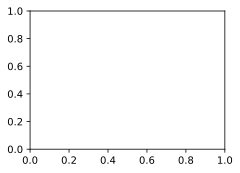

In [35]:
dynamic_net = nn.Sequential(nn.Embedding(num_embeddings=len(vocab),
                                         embedding_dim=embed_size),
                            nn.Embedding(num_embeddings=len(vocab),
                                         embedding_dim=embed_size))

lr, num_epochs = 0.002, 5
train_dynamic_sampling(dynamic_net, lr, num_epochs)

get_similar_tokens('chip', 3, dynamic_net[0])